# Jianjin008 Dataset Processing


In [22]:
import os
import random
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import shutil

In [23]:
# ================== CONFIG ==================
import os
from google.colab import drive
drive.mount('/content/drive')

# Install pv for progress visualization
!apt-get -qq install unrar pv

# Clean destination (no longer needed as we are unzipping directly to drive)
# !rm -rf /content/jianjin008
# !mkdir -p /content/jianjin008

# Quiet unzip into the final drive folder, overriding existing files
!unzip -q -o "/content/drive/MyDrive/Samsung_Datasets/jianjin008.zip" -d "/content/drive/MyDrive/Samsung_Project/jianjin008"

DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008/icip"
REF_PATH = os.path.join(DATASET_PATH, "ref_img")
DIST_PATH = os.path.join(DATASET_PATH, "jnd_img")
MOS_FILE = os.path.join(DATASET_PATH, "mos.txt")
OUTPUT_PATH = "/content/jianjin008_patches" # Keep local for processing speed
PATCHES_DIR = os.path.join(OUTPUT_PATH, "patches")

NUM_SAMPLES = 1000
PATCH_SIZE = 20
CENTER_SIZE = 12
ALPHA = 0.5

os.makedirs(PATCHES_DIR, exist_ok=True)
# The rsync command is no longer needed as we are unzipping directly to the final structure
# !rsync -a /content/jianjin008_raw/icip/ /content/jianjin008/

# Check that the structure is now flattened (check the drive path)
!ls -R "/content/drive/MyDrive/Samsung_Project/jianjin008/icip" | head -20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Samsung_Project/jianjin008/icip:
jnd_img
mos.txt
paper.pdf
README.txt
ref_img

/content/drive/MyDrive/Samsung_Project/jianjin008/icip/jnd_img:
I01_02_01.png
I01_06_01.png
I01_08_01.png
I01_09_01.png
I01_10_01.png
I01_16_01.png
I01_16_02.png
I01_17_01.png
I01_17_02.png
I01_19_01.png
I01_19_02.png
I01_20_01.png


In [24]:
# ================== LOAD MOS ==================
def load_mos_with_names(mos_file):
    mos_dict = {}
    with open(mos_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                # check if the first part looks like a filename (contains a dot)
                if "." in parts[0]:
                    fname, score = parts
                else:
                    score, fname = parts
                try:
                    mos_dict[fname] = float(score)
                except ValueError:
                    print(f"Could not convert score to float for line: {line.strip()}")
                    continue
    return mos_dict

In [25]:
# ================== HELPERS ==================
def compute_psnr(img1, img2):
    arr1, arr2 = np.array(img1, dtype=np.float32), np.array(img2, dtype=np.float32)
    mse = np.mean((arr1 - arr2) ** 2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((255 ** 2) / mse)

def extract_patch(img, x, y, size=20):
    return img.crop((x, y, x + size, y + size))

def fuse_patch(clean_patch, dist_patch, mode="blend", alpha=0.5):
    clean_arr = np.array(clean_patch).astype(np.float32)
    dist_arr = np.array(dist_patch).astype(np.float32)
    h, w, _ = clean_arr.shape
    cx, cy = w // 2, h // 2
    half = CENTER_SIZE // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = x1 + CENTER_SIZE, y1 + CENTER_SIZE

    fused = dist_arr.copy()
    if mode == "copy":
        fused[y1:y2, x1:x2] = clean_arr[y1:y2, x1:x2]

    return Image.fromarray(np.uint8(fused))

## Checking how many images there are:

In [26]:
# ================== LOAD AND SELECT FILES ==================
# Load MOS data
mos_dict = load_mos_with_names(MOS_FILE)

# Select files to process (e.g., all files with MOS scores)
selected_files = list(mos_dict.keys())

# Optionally, limit the number of files for testing
# selected_files = selected_files[:NUM_SAMPLES]

print(f"Loaded MOS data for {len(mos_dict)} files.")
print(f"Selected {len(selected_files)} files for processing.")

Loaded MOS data for 1641 files.
Selected 1641 files for processing.


## Checking how many combinations of images with the same distortion type there are:

In [27]:
from collections import defaultdict
from collections import Counter

# Dictionary to store distortion levels per image and distortion type
distortion_levels_per_image_type = defaultdict(lambda: defaultdict(set))
filtered_distortion_levels = []
filtered_distortion_types = []

num = 0

if os.path.exists(MOS_FILE):
    try:
        with open(MOS_FILE, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    filename = parts[0]
                    # Extract image number, distortion type, and level from the filename
                    # Filename format: IXX_YY_Z.png or IXX_YY_Z.bmp
                    filename_parts = filename.split('_')
                    if len(filename_parts) >= 3:
                        image_number = filename_parts[0] # e.g., I17
                        distortion_type = filename_parts[1] # e.g., 05
                        distortion_level = filename_parts[2].split('.')[0] # e.g., 01, 02, 03
                        distortion_levels_per_image_type[image_number][distortion_type].add(distortion_level)
                    else:
                        print(f"Skipping line with unexpected filename format: {line.strip()}")

        if distortion_levels_per_image_type:
            # Sort by image number and then distortion type for consistent output
            sorted_images = sorted(distortion_levels_per_image_type.keys())
            for image_number in sorted_images:
                sorted_distortion_types = sorted(distortion_levels_per_image_type[image_number].keys())
                for distortion_type in sorted_distortion_types:
                    levels = sorted(list(distortion_levels_per_image_type[image_number][distortion_type])) # Sort levels numerically
                    # Filter to only include those with 3 or more distortion levels
                    if len(levels) >= 3:
                        filtered_distortion_levels.extend(levels)
                        filtered_distortion_types.extend([distortion_type] * len(levels))
                        num = num + 1

            print(f"\nTotal number of unique image and distortion type combinations with 3+ levels: {num}")

        else:
            print(f"No valid filenames found in {MOS_FILE} to extract distortion information.")

    except Exception as e:
        print(f"An error occurred while processing {MOS_FILE}: {e}")

else:
    print(f"File '{MOS_FILE}' not found.")


Total number of unique image and distortion type combinations with 3+ levels: 121


## How many images there are in total that do not fit the theory of slight_flicker + no_flicker

In [28]:
# ================== FILTER FILES ==================
# Create a set of filenames to exclude based on the previous analysis
excluded_filenames = set()
if distortion_levels_per_image_type:
    for image_number, distortion_types in distortion_levels_per_image_type.items():
        for distortion_type, levels in distortion_types.items():
            # Filter to only include those with 3 or more distortion levels
            if len(levels) >= 3:
                # Construct the filenames to exclude for this image_number and distortion_type
                for level in levels:
                    # Assuming the format is always IXX_YY_Z.png or IXX_YY_Z.bmp
                    # Need to check both .png and .bmp extensions
                    excluded_filenames.add(f"{image_number}_{distortion_type}_{level}.png")
                    excluded_filenames.add(f"{image_number}_{distortion_type}_{level}.bmp")

# Filter the selected_files list
original_selected_files_count = len(selected_files)
selected_files = [fname for fname in selected_files if fname not in excluded_filenames]

print(f"Original number of selected files: {original_selected_files_count}")
print(f"Number of files excluded (with 3+ distortion levels): {original_selected_files_count - len(selected_files)}")
print(f"Number of files remaining after filtering: {len(selected_files)}")

Original number of selected files: 1641
Number of files excluded (with 3+ distortion levels): 375
Number of files remaining after filtering: 1266


In [29]:
# ================== CATEGORIZE FILES BASED ON MOS SCORE PAIRS ==================
no_flicker = []
slight_flicker = []
same_score = [] # This list will now also include files generated by blending

# Create a dictionary to group files by their base image and distortion type
# This will help in pairing the images with different distortion levels
file_groups = defaultdict(list)
for fname in selected_files:
    parts = fname.split('_')
    if len(parts) >= 3:
        # Use image number and distortion type as the key for grouping
        base_name = f"{parts[0]}_{parts[1]}"
        file_groups[base_name].append(fname)
    else:
        print(f"Skipping {fname} due to unexpected filename format for grouping.")


# Iterate through the grouped files and compare MOS scores for pairs
for base_name, files in file_groups.items():
    # Assuming that files with the same base_name and distortion type form a pair
    # We can process them in pairs of two. If there's an odd number, the last one is added to slight_flicker.
    files.sort() # Sort to ensure consistent pairing if needed, though not strictly necessary for this logic
    for i in range(0, len(files), 2):
        if i + 1 < len(files):
            file1 = files[i]
            file2 = files[i+1]

            mos1 = mos_dict.get(file1)
            mos2 = mos_dict.get(file2)

            if mos1 is None or mos2 is None:
                print(f"Skipping pair ({file1}, {file2}) due to missing MOS score.")
                continue

            if mos1 < mos2:
                no_flicker.append(file1)
                slight_flicker.append(file2)
            elif mos2 < mos1:
                no_flicker.append(file2)
                slight_flicker.append(file1)
            else:
                # If MOS scores are the same, add both files to the same_score list
                same_score.append(file1)
                same_score.append(file2)

                # Additionally, create a 'blended' representation and add its filename to same_score
                # This assumes you will generate blended images later based on this list.
                # For now, we just add a placeholder filename.
                blended_fname = f"blended_{file1}" # Create a unique name for the blended image
                same_score.append(blended_fname)

        else:  # This handles the case of an unpaired file
             slight_flicker.append(files[i])

print(f"Number of files in 'no_flicker' list: {len(no_flicker)}")
print(f"Number of files in 'slight_flicker' list: {len(slight_flicker)}")
print(f"Number of files in 'same_score' list: {len(same_score)}")

Number of files in 'no_flicker' list: 254
Number of files in 'slight_flicker' list: 966
Number of files in 'same_score' list: 69


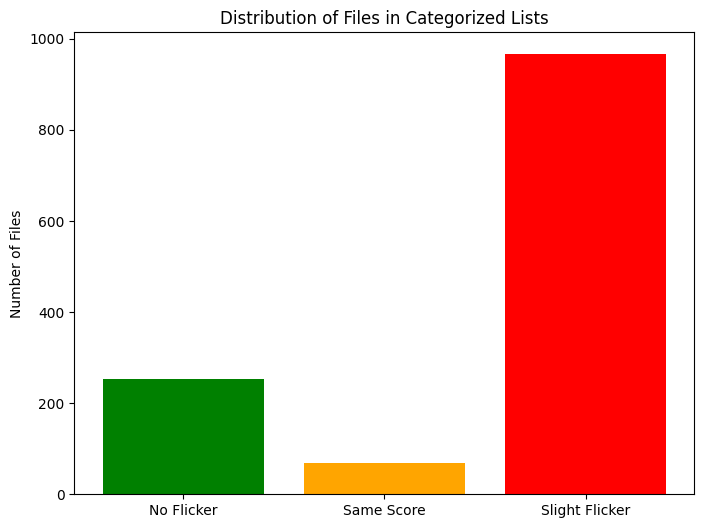

In [30]:
import matplotlib.pyplot as plt

# Create a list of the lengths of the lists
list_counts = [len(no_flicker), len(same_score), len(slight_flicker)]
list_labels = ['No Flicker', 'Same Score', 'Slight Flicker']

plt.figure(figsize=(8, 6))
plt.bar(list_labels, list_counts, color=['green', 'orange', 'red'])
plt.ylabel('Number of Files')
plt.title('Distribution of Files in Categorized Lists')
plt.show()

In [31]:
# ================== FIND MIN/MAX MOS ==================
if mos_dict:
    mos_scores = list(mos_dict.values())
    min_mos = min(mos_scores)
    max_mos = max(mos_scores)
    print(f"Minimum MOS score: {min_mos}")
    print(f"Maximum MOS score: {max_mos}")
else:
    print("MOS dictionary is empty or not loaded.")

Minimum MOS score: 0.79509
Maximum MOS score: 0.98361


In [32]:
# ================== NORMALIZE ALL MOS SCORES [0, 1] ==================
# Load MOS data using the existing function
mos_dict = load_mos_with_names(MOS_FILE)

normalized_mos_dict = {}

if mos_dict:
    mos_scores = list(mos_dict.values())
    min_mos = min(mos_scores)
    max_mos = max(mos_scores)

    if max_mos > min_mos: # Avoid division by zero if all scores are the same
        for fname, score in mos_dict.items():
            normalized_score = (score - min_mos) / (max_mos - min_mos)
            normalized_mos_dict[fname] = normalized_score
    else:
        print("All MOS scores are the same. Cannot perform min-max normalization.")
        # Optionally, assign a default normalized value (e.g., 0.5) if all scores are the same
        for fname, score in mos_dict.items():
             normalized_mos_dict[fname] = 0.5


print(f"Created a dictionary with normalized MOS scores for {len(normalized_mos_dict)} files.")

# Display a few entries from the normalized dictionary
print("\nSample entries from normalized_mos_dict:")
for i, (fname, mos) in enumerate(normalized_mos_dict.items()):
    if i >= 5:
        break
    print(f"{fname}: {mos:.3f}")

# Update the global mos_dict with normalized values for subsequent steps
mos_dict = normalized_mos_dict

# Corrected line to access dictionary values
min_normalized_mos = min(normalized_mos_dict.values())
max_normalized_mos = max(normalized_mos_dict.values())
print(f"Minimum normalized MOS score: {min_normalized_mos}")
print(f"Maximum normalized MOS score: {max_normalized_mos}")

Created a dictionary with normalized MOS scores for 1641 files.

Sample entries from normalized_mos_dict:
I12_01_01.png: 0.397
I17_01_01.png: 0.424
I17_01_02.png: 0.424
I36_01_01.png: 0.424
I39_01_01.png: 0.464
Minimum normalized MOS score: 0.0
Maximum normalized MOS score: 1.0


In [33]:
# ================== NORMALIZE MOS FOR SLIGHT_FLICKER ==================
normalized_slight_flicker_mos = {}

# Iterate through the files in the slight_flicker list
for fname in slight_flicker:
    # Get the normalized MOS score from the normalized_mos_dict
    normalized_mos = normalized_mos_dict.get(fname)

    if normalized_mos is not None:
        normalized_slight_flicker_mos[fname] = normalized_mos
    else:
        print(f"Warning: Normalized MOS score not found for {fname} in normalized_mos_dict. Skipping.")

print(f"Created normalized MOS dictionary for {len(normalized_slight_flicker_mos)} images in 'slight_flicker'.")

# Display a few entries from the normalized dictionary
print("\nSample entries from normalized_slight_flicker_mos:")
for i, (fname, mos) in enumerate(normalized_slight_flicker_mos.items()):
    if i >= 5:
        break
    print(f"{fname}: {mos:.3f}")

Created normalized MOS dictionary for 966 images in 'slight_flicker'.

Sample entries from normalized_slight_flicker_mos:
I12_01_01.png: 0.397
I36_01_01.png: 0.424
I39_01_01.png: 0.464
I55_01_01.png: 0.556
I77_01_01.png: 0.318


In [34]:
# ================== FIND MIN/MAX NORMALIZED MOS ==================
if normalized_slight_flicker_mos:
    normalized_mos_values = list(normalized_slight_flicker_mos.values())
    min_normalized_mos = min(normalized_mos_values)
    max_normalized_mos = max(normalized_mos_values)
    print(f"Minimum normalized MOS score: {min_normalized_mos}")
    print(f"Maximum normalized MOS score: {max_normalized_mos}")
else:
    print("Normalized MOS dictionary is empty or not loaded.")

Minimum normalized MOS score: 0.0016443878633568452
Maximum normalized MOS score: 0.9941120305537877


In [35]:
# ================== HELPERS ==================
def compute_psnr(img1, img2):
    arr1, arr2 = np.array(img1, dtype=np.float32), np.array(img2, dtype=np.float32)
    mse = np.mean((arr1 - arr2) ** 2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((255 ** 2) / mse)

def extract_patch(img, x, y, size=20):
    return img.crop((x, y, x + size, y + size))

def fuse_patch(clean_patch, dist_patch, mode="copy", alpha=0.5):
    clean_arr = np.array(clean_patch).astype(np.float32)
    dist_arr = np.array(dist_patch).astype(np.float32)
    h, w, _ = clean_arr.shape
    cx, cy = w // 2, h // 2
    half = CENTER_SIZE // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = x1 + CENTER_SIZE, y1 + CENTER_SIZE

    fused = dist_arr.copy()
    if mode == "copy":
        fused[y1:y2, x1:x2] = clean_arr[y1:y2, x1:x2]
    else:  # blend
        fused[y1:y2, x1:x2] = alpha * clean_arr[y1:y2, x1:x2] + (1 - alpha) * dist_arr[y1:y2, x1:x2]

    return Image.fromarray(np.uint8(fused))

Processing 966 images from the 'slight_flicker' list...
Skipping I33_17_02.png, distorted not found at /content/drive/MyDrive/Samsung_Project/jianjin008/icip/jnd_img

Total number of patches created: 1930


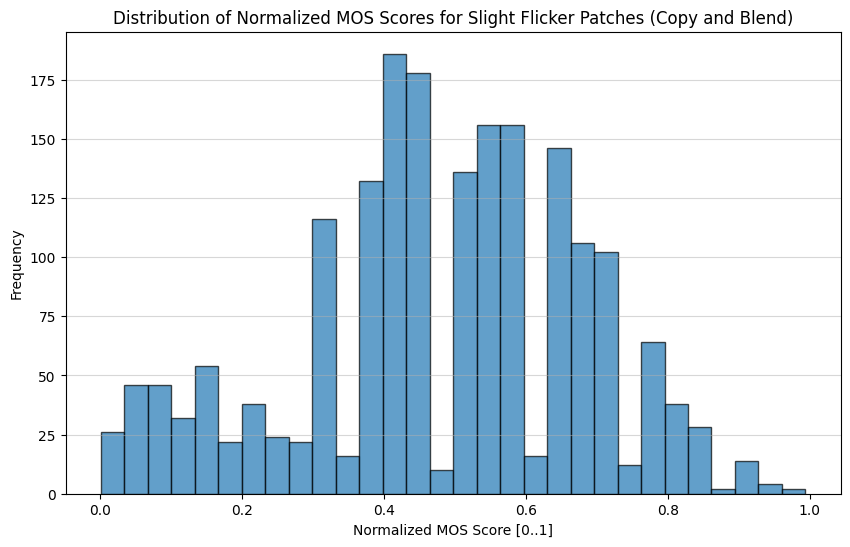

In [36]:
# ================== MAIN LOOP (PROCESS SLIGHT_FLICKER IMAGES) ==================
import random
metadata = []
psnr_values = {} # Use a dictionary to store PSNR values keyed by distorted filename to avoid duplicates

DATASET_NAME = "jianjin008"
processed_files_count = 0 # Counter for all processed patches

# Process only files in the slight_flicker list
files_to_process = slight_flicker

print(f"Processing {len(files_to_process)} images from the 'slight_flicker' list...")

# Define MOS bins and corresponding scores - The provided binning logic will be used instead
# mos_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
# bin_scores = [0, 0.25, 0.5, 0.75, 1.0] # Scores corresponding to the upper bound of each bin (except the last)

# def get_binned_score(normalized_mos, bins, scores):
#     """Assigns a binned score based on normalized MOS."""
#     for i in range(len(bins) - 1):
#         if bins[i] <= normalized_mos < bins[i+1]:
#             return scores[i]
#     # Handle the upper boundary case (normalized_mos == 1.0)
#     if normalized_mos == bins[-1]:
#         return scores[-1]
#     return scores[0] # Default to the lowest score if outside defined bins


for idx, fname in enumerate(files_to_process):

    # Parse filename
    parts = fname.lower().split("_")
    if len(parts) < 3:
        print(f"Skipping {fname}, invalid filename format")
        continue

    ref_id = parts[0].upper()
    # Assuming distortion type is the second part of the filename (e.g., 01, 02)
    distortion_type = parts[1]


    # ----- Reference lookup -----
    clean_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(REF_PATH, f"{ref_id}{ext}")
        if os.path.exists(candidate):
            clean_file = candidate
            break
    if clean_file is None:
        print(f"Skipping {fname}, reference not found at {REF_PATH}")
        continue

    # ----- Distorted lookup -----
    dist_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(DIST_PATH, os.path.splitext(fname)[0] + ext)
        if os.path.exists(candidate):
            dist_file = candidate
            break
    if dist_file is None:
        print(f"Skipping {fname}, distorted not found at {DIST_PATH}")
        continue

    # ----- Load images -----
    try:
        clean_img = Image.open(clean_file).convert("RGB")
        dist_img = Image.open(dist_file).convert("RGB")
    except Exception as e:
        print(f"Error loading images for {fname}: {e}. Skipping.")
        continue

    # Calculate PSNR of the distorted image relative to the clean image ONCE per distorted image
    dist_id  = os.path.splitext(os.path.basename(dist_file))[0]
    if dist_id not in psnr_values:
        dist_psnr = compute_psnr(clean_img, dist_img)
        psnr_values[dist_id] = dist_psnr # Store PSNR keyed by distorted image ID


    w, h = clean_img.size

    # Check if image size is large enough for patching
    if w < PATCH_SIZE or h < PATCH_SIZE:
        print(f"Skipping {fname}, image too small for patching ({w}x{h}).")
        continue

    # Random coords
    x = random.randint(0, w - PATCH_SIZE)
    y = random.randint(0, h - PATCH_SIZE)

    clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
    dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

    # Get MOS
    mos_score = mos_dict.get(fname)
    if mos_score is None:
        print(f"Warning: MOS score not found for {fname}. Skipping metadata.")
        continue

    # Use the provided binning logic
    normalized_score = mos_score # Assuming mos_score is already normalized [0, 1]
    if normalized_score >= 0.66:
        color = "GREEN"
        binned_score = 1
    elif normalized_score >= 0.33:
        color = "ORANGE"
        binned_score = 0.5
    else:
        color = "RED"
        binned_score = 0


    # Process with "copy" method
    method_label_copy = "copy"
    out_name_copy = f"{method_label_copy}_patch_{processed_files_count:04}.png"
    # For "copy" method, we use the distorted patch directly
    dist_patch.save(os.path.join(PATCHES_DIR, out_name_copy))

    metadata.append({
      "unique_sample_id": out_name_copy,
      "clean_image": os.path.basename(clean_file),
      "distorted_image": os.path.basename(dist_file),
      "score": float(mos_score), # Use the normalized MOS score
      "metadata": {
        "method": method_label_copy,
        "image_source": DATASET_NAME,
        "bp_case": f"case{distortion_type}",
        "color": color,  # Use the color from binning
        "score_binned": binned_score, # Use the binned score
        "IQE_workspace_number": 990,
        "mos_original": mos_dict.get(fname, None), # Store original MOS if available
        "mos_normalized": mos_score, # Store normalized MOS
        "roi": [x, y, PATCH_SIZE, PATCH_SIZE],
        "crop_id": dist_id,
        "distorted_psnr": psnr_values.get(dist_id, None) # Get PSNR from the dictionary
      }
    })
    processed_files_count += 1


    # Process with "blend" method
    method_label_blend = "blend"
    out_name_blend = f"{method_label_blend}_patch_{processed_files_count:04}.png"
    # For "blend" method, create a blended patch using the helper function
    blended_patch = fuse_patch(clean_patch, dist_patch, mode="blend", alpha=ALPHA)
    blended_patch.save(os.path.join(PATCHES_DIR, out_name_blend))

    metadata.append({
      "unique_sample_id": out_name_blend,
      "clean_image": os.path.basename(clean_file),
      "distorted_image": os.path.basename(dist_file),
      "score": float(mos_score), # Use the normalized MOS score
      "metadata": {
        "method": method_label_blend,
        "image_source": DATASET_NAME,
        "bp_case": f"case{distortion_type}",
        "color": color,  # Use the color from binning
        "score_binned": binned_score, # Use the binned score
        "IQE_workspace_number": 990,
        "mos_original": mos_dict.get(fname, None), # Store original MOS if available
        "mos_normalized": mos_score, # Store normalized MOS
        "roi": [x, y, PATCH_SIZE, PATCH_SIZE],
        "crop_id": dist_id,
        "distorted_psnr": psnr_values.get(dist_id, None) # Get PSNR from the dictionary
      }
    })
    processed_files_count += 1


# Print the total number of patches created
print(f"\nTotal number of patches created: {processed_files_count}")

# ================== DISPLAY MOS SCORE HISTOGRAM FOR SLIGHT_FLICKER ==================
import matplotlib.pyplot as plt
import numpy as np

# Extract normalized MOS scores from metadata for the processed patches
mos_scores_for_hist = [entry["score"] for entry in metadata if "score" in entry]

if mos_scores_for_hist:
    plt.figure(figsize=(10, 6))
    # Use a reasonable number of bins for MOS scores (e.g., 20 or 30)
    plt.hist(mos_scores_for_hist, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel("Normalized MOS Score [0..1]")
    plt.ylabel("Frequency")
    plt.title("Distribution of Normalized MOS Scores for Slight Flicker Patches (Copy and Blend)")
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()
else:
    print("No normalized MOS scores available to display histogram.")

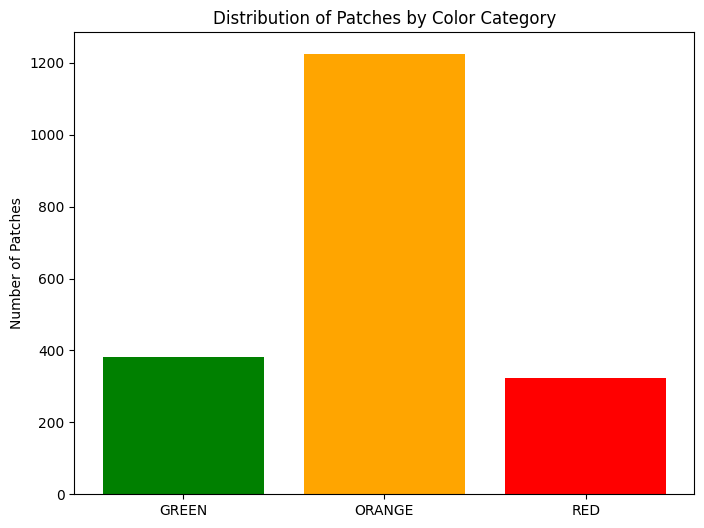

In [37]:
# ================== DISPLAY PATCH COUNTS BY COLOR (BAR CHART) ==================
from collections import Counter
import matplotlib.pyplot as plt

# Count patches by color category from metadata
color_counts = Counter(entry.get("metadata", {}).get("color") for entry in metadata if entry.get("metadata", {}).get("color") in ["GREEN", "ORANGE", "RED"])

# Create lists for labels and counts for plotting
list_labels = list(color_counts.keys())
list_counts = list(color_counts.values())

# Ensure consistent order for plotting
ordered_labels = ["GREEN", "ORANGE", "RED"]
ordered_counts = [color_counts.get(label, 0) for label in ordered_labels]

plt.figure(figsize=(8, 6))
plt.bar(ordered_labels, ordered_counts, color=['green', 'orange', 'red'])
plt.ylabel('Number of Patches')
plt.title('Distribution of Patches by Color Category')
plt.show()

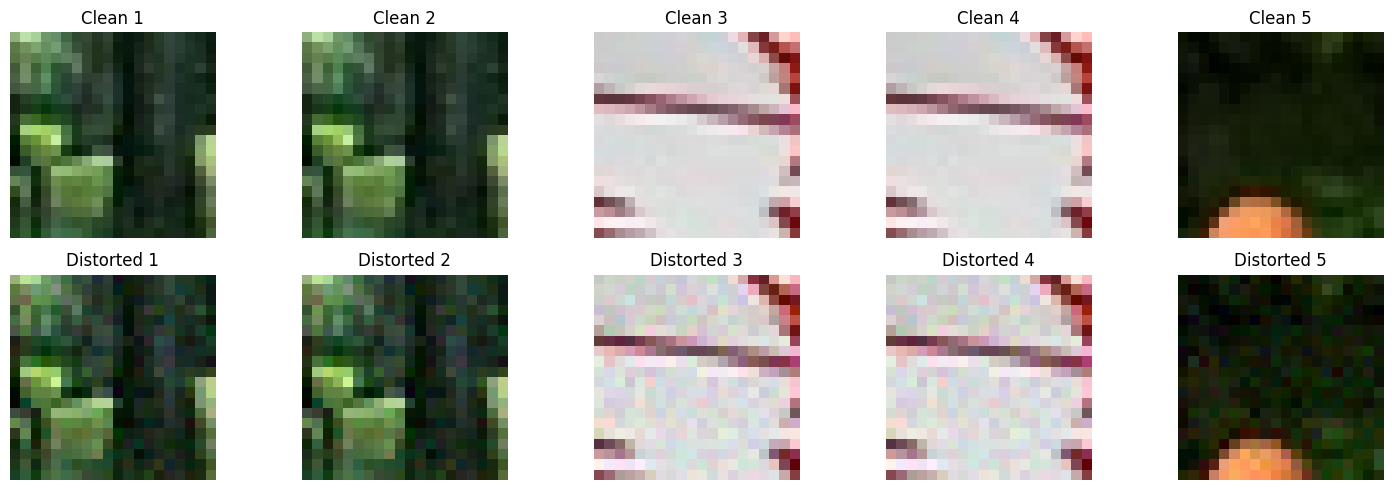

In [38]:
# ================== DISPLAY FIRST 5 PATCHES ==================
def display_first_patches(num_samples=5):
    # Assuming the patches are named sequentially like "copy_patch_0000.png", "copy_patch_0001.png", etc.
    # and the metadata list is in the same order
    if not metadata:
        print("Metadata is empty. Please run the patch generation cell first.")
        return

    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(metadata))):
        metadata_entry = metadata[i]

        clean_img_name = metadata_entry["clean_image"]
        dist_img_name = metadata_entry["distorted_image"]
        x, y, _, _ = metadata_entry["metadata"]["roi"]

        # Load original clean and distorted images
        clean_img_path = os.path.join(REF_PATH, clean_img_name)
        dist_img_path = os.path.join(DIST_PATH, dist_img_name)

        if os.path.exists(clean_img_path) and os.path.exists(dist_img_path):
            clean_img = Image.open(clean_img_path).convert("RGB")
            dist_img = Image.open(dist_img_path).convert("RGB")

            # Extract patches using the saved coordinates
            clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
            dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

            # Display clean patch
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(clean_patch)
            plt.title(f"Clean {i+1}")
            plt.axis("off")

            # Display distorted patch
            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(dist_patch)
            plt.title(f"Distorted {i+1}")
            plt.axis("off")
        else:
            print(f"Original images not found for metadata entry {i}")

    plt.tight_layout()
    plt.show()

display_first_patches(5)

In [39]:
# ================== COMPUTE AND SUMMARIZE PSNR FOR ALL PAIRED PATCHES ==================
def compute_paired_psnr_stats():
    """Computes PSNR for all copy and blend patch pairs and prints summary statistics."""
    if not metadata:
        print("Metadata is empty. Please run the patch generation cell first.")
        return

    print("Computing PSNR for all copy and blend patch pairs...")

    paired_entries = []
    i = 0
    while i < len(metadata) - 1:
        entry1 = metadata[i]
        entry2 = metadata[i+1]

        uid1 = entry1.get("unique_sample_id", "")
        uid2 = entry2.get("unique_sample_id", "")

        try:
            num1 = int(uid1.split('_')[-1].split('.')[0])
            num2 = int(uid2.split('_')[-1].split('.')[0])
            method1 = uid1.split('_')[0]
            method2 = uid2.split('_')[0]

            if num2 == num1 + 1 and ((method1 == "copy" and method2 == "blend") or (method1 == "blend" and method2 == "copy")):
                 if method1 == "copy":
                     paired_entries.append((entry1, entry2))
                 else:
                     paired_entries.append((entry2, entry1))
                 i += 2
            else:
                i += 1

        except (ValueError, IndexError):
            i += 1
            continue

    if not paired_entries:
        print("No copy/blend patch pairs found in metadata.")
        return

    psnr_values = []
    for copy_entry, blend_entry in paired_entries:
        copy_patch_name = copy_entry["unique_sample_id"]
        blend_patch_name = blend_entry["unique_sample_id"]

        copy_patch_path = os.path.join(PATCHES_DIR, copy_patch_name)
        blend_patch_path = os.path.join(PATCHES_DIR, blend_patch_name)

        if os.path.exists(copy_patch_path) and os.path.exists(blend_patch_path):
            try:
                copy_patch_img = Image.open(copy_patch_path)
                blend_patch_img = Image.open(blend_patch_path)

                # Calculate PSNR between the copy and blend patches
                psnr_value = compute_psnr(copy_patch_img, blend_patch_img)
                # Only include finite PSNR values in the statistics
                if not np.isinf(psnr_value):
                    psnr_values.append(psnr_value)

            except Exception as e:
                print(f"Error loading or computing PSNR for pair: {copy_patch_name}, {blend_patch_name}: {e}")
                continue
        else:
            print(f"Patch files not found for pair: {copy_patch_path} or {blend_patch_path}")

    if psnr_values:
        # Calculate and print summary statistics
        mean_psnr = np.mean(psnr_values)
        median_psnr = np.median(psnr_values)
        std_psnr = np.std(psnr_values)

        print("\nSummary Statistics for PSNR between Copy and Blend Patches:")
        print(f"Number of pairs analyzed: {len(psnr_values)}")
        print(f"Mean PSNR: {mean_psnr:.2f} dB")
        print(f"Median PSNR: {median_psnr:.2f} dB")
        print(f"Standard Deviation of PSNR: {std_psnr:.2f} dB")
    else:
        print("\nNo finite PSNR values were computed for the paired patches.")


# Call the function to compute and display stats
compute_paired_psnr_stats()

Computing PSNR for all copy and blend patch pairs...

Summary Statistics for PSNR between Copy and Blend Patches:
Number of pairs analyzed: 694
Mean PSNR: 44.94 dB
Median PSNR: 44.37 dB
Standard Deviation of PSNR: 6.19 dB


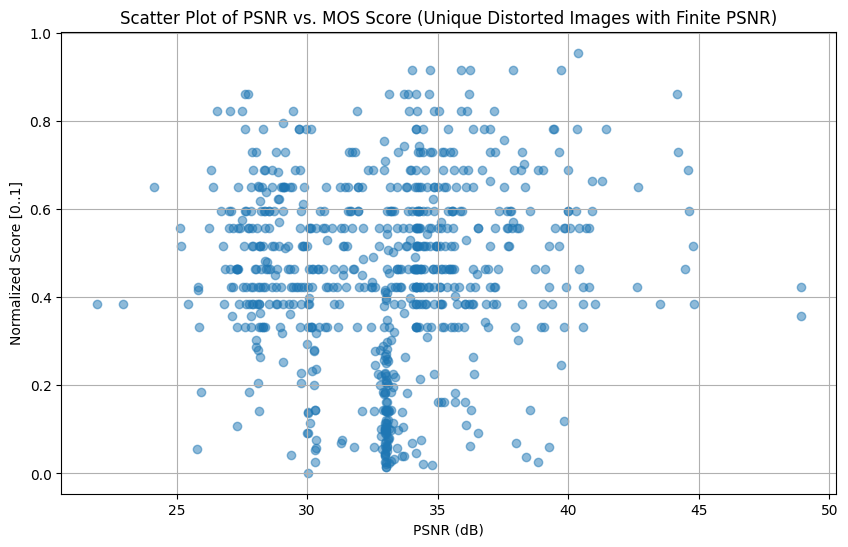

In [40]:
# ================== DISPLAY PSNR VS. MOS SCORE SCATTER PLOT ==================

# Extract PSNR values and normalized MOS scores from metadata for all patches
# that have a 'distorted_psnr' entry in their metadata.
# Filter out infinite PSNR values for the scatter plot to improve visualization.
psnr_values_for_scatter = []
mos_scores_for_scatter = []

# Define a large finite value to replace infinite PSNR
large_finite_value = 1000.0 # This is now defined in the printing cell

psnr_values_for_histogram = [] # Keep a separate list for the histogram including replaced infinite values

processed_distorted_images = set() # To keep track of distorted images already processed

for entry in metadata:
    # Assuming 'distorted_psnr' is the relevant PSNR metric to plot against MOS
    # and 'crop_id' uniquely identifies the distorted image.
    dist_id = entry.get("metadata", {}).get("crop_id")

    if dist_id and dist_id not in processed_distorted_images and "distorted_psnr" in entry.get("metadata", {}):
        psnr = entry["metadata"]["distorted_psnr"]
        mos_score = entry["score"]

        # For the scatter plot, only include finite PSNR values
        if not np.isinf(psnr):
            psnr_values_for_scatter.append(psnr)
            mos_scores_for_scatter.append(mos_score)

        # For the histogram, replace infinite PSNR values with a large finite value
        if np.isinf(psnr):
            psnr_values_for_histogram.append(large_finite_value) # Use the large finite value for histogram
        else:
             psnr_values_for_histogram.append(psnr)

        processed_distorted_images.add(dist_id) # Mark this distorted image as processed


# Check if there is data to plot for the scatter plot
if psnr_values_for_scatter and len(psnr_values_for_scatter) == len(mos_scores_for_scatter):
    plt.figure(figsize=(10, 6))
    plt.scatter(psnr_values_for_scatter, mos_scores_for_scatter, alpha=0.5)
    plt.xlabel("PSNR (dB)")
    plt.ylabel("Normalized Score [0..1]")
    plt.title("Scatter Plot of PSNR vs. MOS Score (Unique Distorted Images with Finite PSNR)") # Clarify title
    plt.grid(True)
    plt.show()
else:
    print("Not enough data or data size mismatch to plot PSNR vs. MOS scatter plot for unique finite PSNR values.")
    # Print lengths for debugging if needed
    # print(f"Length of psnr_values_for_scatter: {len(psnr_values_for_scatter)}")
    # print(f"Length of mos_scores_for_scatter: {len(mos_scores_for_scatter)}")

In [41]:
# ================== SAVE RESULTS ==================
# Your Drive target
drive_save_dir = "/content/drive/MyDrive/Samsung_Project/jianjin008_patches"

# Ensure subfolders
copy_dir = os.path.join(drive_save_dir, "copy")
# blended_dir = os.path.join(drive_save_dir, "blended") # Directory for blended patches - No longer needed as all go to copy

# --- Clean destination directories before saving ---
print(f"Cleaning destination directory: {drive_save_dir}")
if os.path.exists(drive_save_dir):
    # Be cautious with rm -rf on Drive paths. Let's just remove the specific subdirectories we manage.
    print(f"Removing existing copy directory: {copy_dir}")
    try:
        shutil.rmtree(copy_dir)
    except FileNotFoundError:
        print(f"Directory {copy_dir} not found, skipping removal.")
    except Exception as e:
        print(f"Error removing directory {copy_dir}: {e}")

    # # Removing blended directory is no longer necessary if all go to copy
    # print(f"Removing existing blended directory: {blended_dir}")
    # try:
    #     shutil.rmtree(blended_dir)
    # except FileNotFoundError:
    #     print(f"Directory {blended_dir} not found, skipping removal.")
    # except Exception as e:
    #     print(f"Error removing directory {blended_dir}: {e}")

    # Remove known non_image_files from the main directory
    known_non_image_files = ["metadata.json", "psnr_histogram.png"]
    for fname in known_non_image_files:
        fpath = os.path.join(drive_save_dir, fname)
        if os.path.exists(fpath):
            print(f"Removing existing file: {fpath}")
            try:
                os.remove(fpath)
            except Exception as e:
                 print(f"Error removing file {fpath}: {e}")


os.makedirs(drive_save_dir, exist_ok=True) # Recreate the main directory if it was somehow removed
os.makedirs(copy_dir, exist_ok=True) # Recreate the copy directory
# os.makedirs(blended_dir, exist_ok=True) # Create the blended directory - No longer needed


def is_image(path):
    return os.path.splitext(path)[1].lower() in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

# --- Modified saving logic ---
# Create a set of unique_sample_ids from the balanced metadata
valid_patch_uids = {entry["unique_sample_id"] for entry in metadata}

src_root = "/content/jianjin008_patches"
saved_patch_count = 0 # Counter for patches successfully saved

print(f"Copying balanced patches from local directory: {src_root}")

# Iterate through the files in the local patches directory
for root, _, files in os.walk(src_root):
    for fname in files:
        src_path = os.path.join(root, fname)
        # Check if the file is an image and its name is in the valid_patch_uids set
        if is_image(fname) and fname in valid_patch_uids:
            dst_path = os.path.join(copy_dir, fname) # Save all balanced patches to the 'copy' subdirectory
            try:
                shutil.copy2(src_path, dst_path)
                saved_patch_count += 1
            except Exception as e:
                print(f"Error copying balanced patch file {src_path} to {dst_path}: {e}")
        elif fname == "psnr_histogram.png": # Save the PSNR histogram separately
             dst_path = os.path.join(drive_save_dir, fname)
             try:
                 shutil.copy2(src_path, dst_path)
                 print(f"Saved PSNR histogram to {dst_path}")
             except Exception as e:
                  print(f"Error copying PSNR histogram {src_path} to {dst_path}: {e}")
        # Other files (like the local metadata.json which we will overwrite) are not explicitly copied here.

# --- Added conversion for JSON serialization ---
def convert_floats(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_floats(elem) for elem in obj]
    else:
        return obj

# Convert float32 objects in metadata before saving
serializable_metadata = convert_floats(metadata)
# --- End Added conversion ---


# Save the balanced metadata to a JSON file in the main drive_save_dir
metadata_save_path = os.path.join(drive_save_dir, "metadata.json")
try:
    with open(metadata_save_path, "w") as f:
        json.dump(serializable_metadata, f, indent=2) # Use the converted metadata
    print(f"Saved balanced metadata to: {metadata_save_path}")
except Exception as e:
    print(f"Error saving metadata to {metadata_save_path}: {e}")

print(f"\nSaved balanced patches and metadata to: {drive_save_dir}")
print(f"Total balanced image files saved to copy/ subdirectory: {saved_patch_count}")


# Verify counts by listing files
try:
    print("\nSample files in copy/ directory:", sorted(os.listdir(copy_dir))[:5])
except FileNotFoundError:
    print("\nCopy directory not found after saving.")

try:
    main_dir_files = [f for f in os.listdir(drive_save_dir) if os.path.isfile(os.path.join(drive_save_dir, f))]
    print("Files in main drive_save_dir:", sorted(main_dir_files))
except FileNotFoundError:
     print("\nMain output directory not found after saving.")

# Count PNG files in copy subdirectory (should match saved_patch_count)
copy_png_count = 0
if os.path.exists(copy_dir):
    for root, _, files in os.walk(copy_dir):
        for fname in files:
            if fname.lower().endswith(".png"):
                copy_png_count += 1
    print(f"\nNumber of PNG files in {copy_dir}: {copy_png_count}")

Cleaning destination directory: /content/drive/MyDrive/Samsung_Project/jianjin008_patches
Removing existing copy directory: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/copy
Removing existing file: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/metadata.json
Copying balanced patches from local directory: /content/jianjin008_patches
Saved balanced metadata to: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/metadata.json

Saved balanced patches and metadata to: /content/drive/MyDrive/Samsung_Project/jianjin008_patches
Total balanced image files saved to copy/ subdirectory: 1930

Sample files in copy/ directory: ['blend_patch_0001.png', 'blend_patch_0003.png', 'blend_patch_0005.png', 'blend_patch_0007.png', 'blend_patch_0009.png']
Files in main drive_save_dir: ['metadata.json', 'test.json', 'train.json']

Number of PNG files in /content/drive/MyDrive/Samsung_Project/jianjin008_patches/copy: 1930
